<a href="https://colab.research.google.com/github/helincesxyz/ChatGPT-Cheater-Detection-in-Online-Games/blob/main/ChatGPTCheaterDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [144]:
#import necesessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import MinCovDet
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import mahalanobis
from sklearn.preprocessing import StandardScaler
from statsmodels.nonparametric.kernel_density import KDEMultivariate
import statsmodels.api as sm
from scipy import stats


# PART 1: Read And Normalize Data

In [145]:
# read the data
df = pd.read_csv('memoire.csv', sep=';', header=0, index_col = 0 )

In [146]:
# Remove missing values
df = df.replace('?', np.nan).dropna()
df = df.dropna()

In [147]:
# Normalize the data
scaler = MinMaxScaler()
df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [148]:
# check the data for more accuracy
# get the number of variables (columns)
num_vars = df.shape[1]

# print the number of variables
print('The number of variables is:', num_vars)

num_rows = df.shape[0]

# print the number of rows
print('The number of rows is:', num_rows)

# print the first 5 rows of the data frame to check if it was read correctly
print(df.head())

The number of variables is: 26
The number of rows is: 7263
      Score     Kills    Deaths    K/D      Damage  Headshots  Dominations  \
0   90825.0   64010.0   43415.0   1.47   5469199.0    30791.0        159.0   
1   37177.0   23354.0   16610.0   1.41  12424189.0     5104.0       2956.0   
2  175099.0  377607.0  340137.0   1.11  11308366.0    66327.0        218.0   
3   20899.0  206371.0   16340.0  12.63   8809755.0    13478.0   34534577.0   
4   54966.0   18610.0   27416.0   0.68   2430503.0     5269.0       2141.0   

   Shots Fired  Shots Hit  Shots Accuracy  ...  Hostages Rescued      MVP  \
0     445411.0    92913.0            20.9  ...             501.0   9954.0   
1    2156088.0  1385405.0            64.3  ...             807.0   1626.0   
2    1022660.0   591692.0            57.9  ...             531.0  46023.0   
3     216841.0    98468.0            45.4  ...           93455.0   2180.0   
4     294100.0    73146.0            24.9  ...            2138.0   3346.0   

      Win

In [149]:
# Convert data to float
df = df.astype(str) # convert to strings first
df = df.apply(lambda x: x.str.replace(',', '.')).astype(float)

In [78]:
# Perform data scaling and normalization
scaler = StandardScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [79]:

# create the correlation matrix
corr_matrix = df.corr()

# round the values in the matrix to 2 decimal places
corr_matrix = corr_matrix.round(2)

# print the correlation matrix
print(corr_matrix)

# export the correlation matrix as a CSV file with 2 digits of accuracy
corr_matrix.to_csv('correlation.csv', float_format='%.2f', index=False)


with open("correlation.csv", "r") as f:
    content = f.read()



                      Score  Kills  Deaths   K/D  Damage  Headshots  \
Score                  1.00   0.11    0.12 -0.01    0.08       0.09   
Kills                  0.11   1.00    0.87  0.11    0.59       0.83   
Deaths                 0.12   0.87    1.00 -0.09    0.59       0.81   
K/D                   -0.01   0.11   -0.09  1.00   -0.00       0.02   
Damage                 0.08   0.59    0.59 -0.00    1.00       0.55   
Headshots              0.09   0.83    0.81  0.02    0.55       1.00   
Dominations           -0.00   0.03   -0.01  0.18    0.00      -0.00   
Shots Fired            0.04   0.41    0.29  0.08    0.21       0.27   
Shots Hit              0.03   0.19    0.20 -0.01    0.14       0.18   
Shots Accuracy         0.03   0.06    0.01  0.30    0.05       0.20   
Snipers Killed         0.01   0.08    0.04  0.18    0.04       0.04   
Domination Overkills   0.08   0.24    0.15  0.16    0.17       0.22   
Domination Revenges    0.08   0.26    0.25  0.04    0.19       0.18   
Bombs 

# PART 2: Application Of Machine Learning Models

MAHALONOBIS

In [180]:
#MAHALONOBIS

# estimate the center and covariance matrix using the MCD estimator

mcd = MinCovDet().fit(df)
center = mcd.location_
covariance = mcd.covariance_


mcd = MinCovDet(support_fraction=0.99999)

# print the covariance matrix
print("Covariance matrix:\n", covariance)

# print the center
print("Center of the data:\n", center)


Covariance matrix:
 [[ 3.56158074e+09  1.07039035e+09  9.64868456e+08 ... -1.74503475e+05
  -6.06321507e+01  5.33124100e+01]
 [ 1.07039035e+09  3.88525905e+08  3.50973675e+08 ... -5.56644386e+04
  -1.34685799e+01  1.95190897e+01]
 [ 9.64868456e+08  3.50973675e+08  3.36026576e+08 ... -5.80836188e+04
  -2.00017071e+01  9.46275700e+00]
 ...
 [-1.74503475e+05 -5.56644386e+04 -5.80836188e+04 ...  2.22347523e+02
   3.88635973e-01  1.31800013e-01]
 [-6.06321507e+01 -1.34685799e+01 -2.00017071e+01 ...  3.88635973e-01
   9.65483047e-04  2.28810338e-04]
 [ 5.33124100e+01  1.95190897e+01  9.46275700e+00 ...  1.31800013e-01
   2.28810338e-04  1.09627542e-04]]
Center of the data:
 [ 6.81291179e+04  2.36181131e+04  2.11560164e+04  1.23796328e+00
  3.37745224e+06  9.26054603e+03  1.98231457e+02  4.14493398e+05
  8.10050372e+04  2.00601111e+01  1.65222058e+03  2.05744141e+02
  6.72469195e+01  1.04008166e+03  2.36216236e+02  6.04467686e+07
  4.16755255e+01  2.50338633e+03  4.84521624e+02  1.66706934e-0

In [181]:
mcd = MinCovDet(support_fraction=0.99999).fit(df)
center = mcd.location_
covariance = mcd.covariance_

# Calculate the Mahalanobis distance for each observation
distances = []
for i in range(len(df)):
    x = df.iloc[i].values
    try:
        distance = mahalanobis(x, center, np.linalg.inv(covariance))
    except np.linalg.LinAlgError:
        # Handle the case of a singular matrix
        distance = np.nan
    if np.isnan(distance):
        distance = np.nanmean(distances)
    distances.append(distance)

# Print the distances
print("Mahalanobis distances:\n", distances)


<ipython-input-181-ba02e3007f6b>:15: RuntimeWarning: Mean of empty slice
  distance = np.nanmean(distances)


Mahalanobis distances:
 [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 

In [153]:
# replace missing values with the mean value
distances_no_missing = np.nan_to_num(distances, nan=np.nanmean(distances))

# calculate descriptive statistics of distances with missing values replaced
distances_mean = np.mean(distances_no_missing)
distances_std = np.std(distances_no_missing)
distances_min = np.min(distances_no_missing)
distances_max = np.max(distances_no_missing)
distances_25th_percentile = np.percentile(distances_no_missing, 25)
distances_50th_percentile = np.percentile(distances_no_missing, 50)
distances_75th_percentile = np.percentile(distances_no_missing, 75)

# print the descriptive statistics
print("Mean distance:", distances_mean)
print("Standard deviation of distance:", distances_std)
print("Minimum distance:", distances_min)
print("Maximum distance:", distances_max)
print("25th percentile of distance:", distances_25th_percentile)
print("50th percentile of distance:", distances_50th_percentile)
print("75th percentile of distance:", distances_75th_percentile)

Mean distance: 227.81081418385088
Standard deviation of distance: 7219.6447112841715
Minimum distance: 0.03516460695910943
Maximum distance: 434054.6490894534
25th percentile of distance: 4.309601953445405
50th percentile of distance: 8.064623460725725
75th percentile of distance: 23.608799780850568


In [154]:
# get the indices of the sorted distances_no_missing array
sorted_indices = np.argsort(distances_no_missing)

# print the top 10 values
print("Top 10 distances_no_missing values:")
for i in range(10):
    idx = sorted_indices[-(i+1)]
    value = distances_no_missing[idx]
    print("{}. {}".format(i+1, value))

# print the bottom 10 values
print("\nBottom 10 distances_no_missing values:")
for i in range(10):
    idx = sorted_indices[i]
    value = distances_no_missing[idx]
    print("{}. {}".format(i+1, value))

Top 10 distances_no_missing values:
1. 434054.6490894534
2. 434054.6490894534
3. 19272.13546487708
4. 13938.913672040855
5. 11802.68122676124
6. 9962.651169578761
7. 8934.00987477796
8. 7786.016837476852
9. 7427.247198482455
10. 7000.144314609469

Bottom 10 distances_no_missing values:
1. 0.03516460695910943
2. 0.11700064311539769
3. 0.19569762571364313
4. 0.2583408110053163
5. 0.26806422136034996
6. 0.2718971727610509
7. 0.2998529502062605
8. 0.3043783179097435
9. 0.39052744286129204
10. 0.3972398195432255


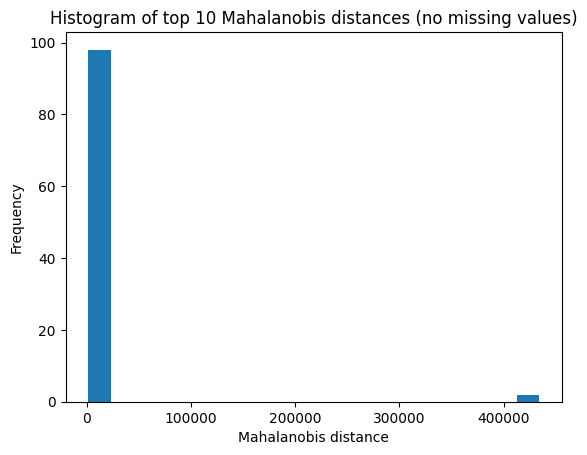

In [155]:
# get the indices of the sorted distances_no_missing array
sorted_indices = np.argsort(distances_no_missing)
# select the top 10 distances_no_missing values
top_10_distances = distances_no_missing[np.argsort(distances_no_missing)[-100:]]

# create a histogram of the top 10 distances
plt.hist(top_10_distances, bins=20)
plt.xlabel("Mahalanobis distance")
plt.ylabel("Frequency")
plt.title("Histogram of top 10 Mahalanobis distances (no missing values)")
plt.show()

In [156]:
# Set the Mahalanobis distance threshold for outliers
threshold = 900

# Create a boolean mask indicating outlier rows
outlier_mask = distances_no_missing > threshold

# Count the number of outliers
num_outliers = sum(outlier_mask)

# Print the number of outliers
print("Number of outliers based on Mahalanobis: {}".format(num_outliers))


Number of outliers based on Mahalanobis: 175


In [157]:


# Create a new column "IsMahanOutlier" in the DataFrame
df["isOutlierMahan"] = pd.Series(outlier_mask, index=df.index)

# Create a new column "OutlierScoreMahan" in the DataFrame
df["MahanOutScore"] = pd.Series(distances_no_missing, index=df.index)

# Print the rows that are outliers
outlier_rows = df[df["isOutlierMahan"] == True]
print(outlier_rows)


         Score     Kills    Deaths    K/D      Damage  Headshots  Dominations  \
0      90825.0   64010.0   43415.0   1.47   5469199.0    30791.0        159.0   
1      37177.0   23354.0   16610.0   1.41  12424189.0     5104.0       2956.0   
2     175099.0  377607.0  340137.0   1.11  11308366.0    66327.0        218.0   
3      20899.0  206371.0   16340.0  12.63   8809755.0    13478.0   34534577.0   
4      54966.0   18610.0   27416.0   0.68   2430503.0     5269.0       2141.0   
...        ...       ...       ...    ...         ...        ...          ...   
1357   10754.0    4722.0    2751.0   1.72    630489.0     1295.0         14.0   
1385   19354.0    6504.0    3594.0   1.81    935466.0     3472.0         63.0   
1387   11295.0    3504.0    3800.0   0.92    507245.0     1374.0         28.0   
1404   37541.0   20845.0    8534.0   2.44   2480818.0     4638.0         65.0   
2396  234119.0  109835.0   58387.0   1.88   9010983.0    29540.0       2526.0   

      Shots Fired  Shots Hi

KNN

In [158]:

# Check if there are still rows in the data frame
if df_normalized.shape[0] == 0:
    print('Error: all rows were removed during pre-processing')
else:
    # Initialize the kNN model
    nn = NearestNeighbors(n_neighbors=5, algorithm='auto')

    # Fit the model to the normalized data
    nn.fit(df_normalized)

    # Calculate the distances to the kth nearest neighbor
    distances, indices = nn.kneighbors(df_normalized)
    
    # Add the distances to the data frame
    df_normalized['Distance to kth NN'] = distances[:, -1]
    
   

    # Find the highest kNN distances (outliers)
    highest_distances = df_normalized.sort_values(by='Distance to kth NN', ascending=False).head(10)
    print("\nTop 10 highest distances:")
    print(highest_distances[['Distance to kth NN']].rename_axis('Row number'))

    # Find the lowest kNN distances (inliers)
    lowest_distances = df_normalized.sort_values(by='Distance to kth NN').head(10)
    print("\nTop 10 lowest distances:")
    print(lowest_distances[['Distance to kth NN']].rename_axis('Row number'))


Top 10 highest distances:
            Distance to kth NN
Row number                    
3                     2.140105
13                    2.140105
402                   1.494746
70                    1.393763
36                    1.375112
30                    1.195571
2396                  1.011499
26                    1.001565
40                    1.001337
5569                  0.981674

Top 10 lowest distances:
            Distance to kth NN
Row number                    
784                   0.004917
3014                  0.005451
5404                  0.005527
4432                  0.005548
1709                  0.005737
136                   0.005750
1468                  0.005825
2676                  0.005831
5559                  0.005967
3611                  0.005996


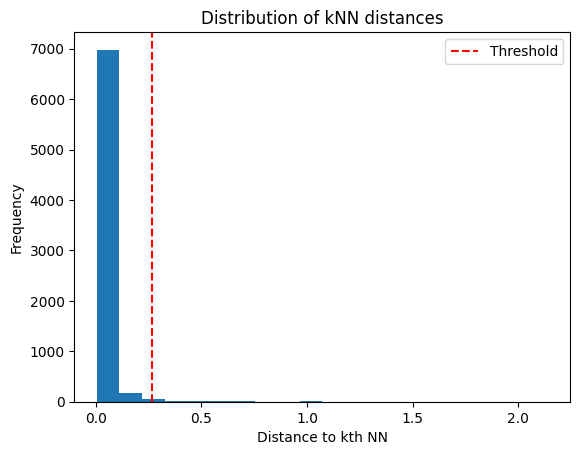

In [159]:


# Plot a histogram of the kNN distances
plt.hist(df_normalized['Distance to kth NN'], bins=20)

# Plot a vertical line to indicate the threshold for outliers
threshold = df_normalized['Distance to kth NN'].quantile(0.99) 
plt.axvline(threshold, color='r', linestyle='--', label='Threshold')

plt.title('Distribution of kNN distances')
plt.xlabel('Distance to kth NN')
plt.ylabel('Frequency')
plt.legend()
plt.show()


In [160]:
# Set the threshold for high values
threshold_high = 0.2

# Filter the rows with high values (potential outliers)
high_value_rows = df_normalized[df_normalized['Distance to kth NN'] > threshold_high]

# Print the rows with high values
print("Rows with high values (potential outliers):")
print(high_value_rows[['Distance to kth NN']].rename_axis('Row number'))


Rows with high values (potential outliers):
            Distance to kth NN
Row number                    
0                     0.722772
1                     0.763120
2                     0.529517
3                     2.140105
4                     0.374330
...                        ...
6978                  0.237083
7039                  0.238666
7045                  0.429837
7224                  0.545108
7255                  0.291871

[127 rows x 1 columns]


In [179]:
# Create a boolean column indicating if the row is an outlier
df['isKNNOutlier'] = df_normalized['Distance to kth NN'] > threshold_high

# Create a string column with the outlier score
df['KNNOutScore'] = df_normalized['Distance to kth NN'].astype(str)

# Filter and print only the rows where isKNNOutlier is True
outlier_rows = df[df['isKNNOutlier'] == True]
print(outlier_rows)


          Score     Kills    Deaths    K/D      Damage  Headshots  \
0       90825.0   64010.0   43415.0   1.47   5469199.0    30791.0   
1       37177.0   23354.0   16610.0   1.41  12424189.0     5104.0   
2      175099.0  377607.0  340137.0   1.11  11308366.0    66327.0   
3       20899.0  206371.0   16340.0  12.63   8809755.0    13478.0   
4       54966.0   18610.0   27416.0   0.68   2430503.0     5269.0   
...         ...       ...       ...    ...         ...        ...   
6978   885093.0  373525.0  266803.0   1.40  56878122.0   144620.0   
7039   596469.0  308290.0  221408.0   1.39  44622161.0   182929.0   
7045   110826.0   35784.0   58557.0   0.61   4852438.0    12036.0   
7224    22094.0   21320.0    1042.0  20.46   1058673.0    10118.0   
7255  2830568.0  259640.0  230806.0   1.12  35450543.0    89373.0   

      Dominations  Shots Fired  Shots Hit  Shots Accuracy  ...  Win %  \
0           159.0     445411.0    92913.0            20.9  ...   49.9   
1          2956.0    2156

Local Outlier Factor (LOF)

Top 10 outliers:
      Row Number  Outlier Score
1117        1117              1
3975        3975              1
567          567              1
2956        2956              1
1783        1783              1
3517        3517              1
941          941              1
3967        3967              1
6779        6779              1
304          304              1


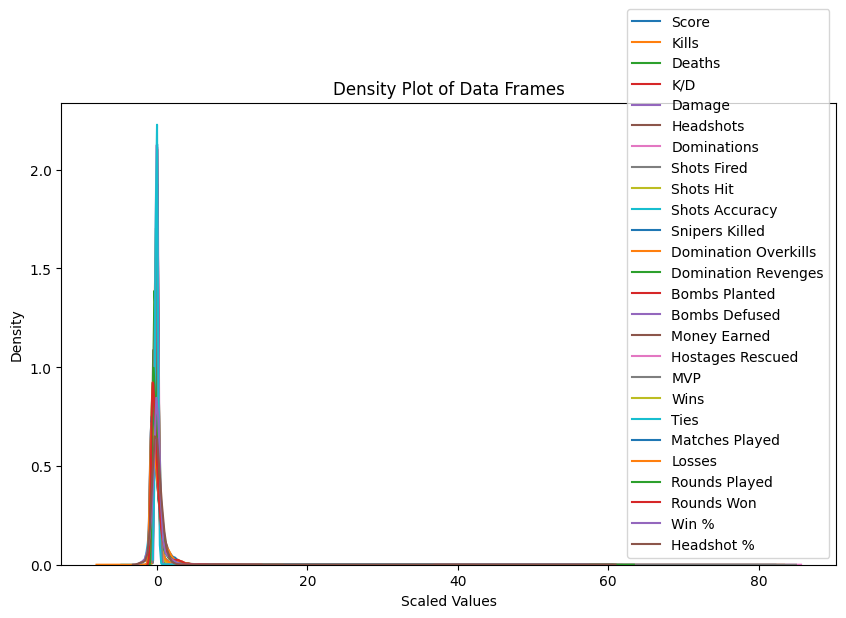

In [162]:

# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=5, contamination='auto', metric='euclidean')

# Fit the model to the data and predict outlier scores
outlier_scores = -lof.fit_predict(df_scaled)

# Create a DataFrame with row numbers and outlier scores
outliers = pd.DataFrame({'Row Number': df.index, 'Outlier Score': outlier_scores})

# Sort the DataFrame by the outlier scores
outliers_sorted = outliers.sort_values(by='Outlier Score', ascending=False)

# Print the top 10 outliers with row numbers and scores
print("Top 10 outliers:")
print(outliers_sorted.head(10))

# Plot density distribution of the data frames
plt.figure(figsize=(10, 6))
for col in df_scaled.columns:
    sns.kdeplot(df_scaled[col], label=col)
plt.title("Density Plot of Data Frames")
plt.xlabel("Scaled Values")
plt.ylabel("Density")
plt.legend()
plt.show()


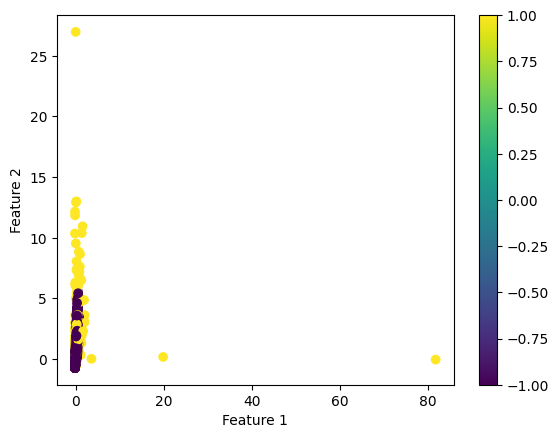

In [163]:
# LOF
# Fit the LOF model to the data and predict outlier scores
lof = LocalOutlierFactor(n_neighbors=70, contamination='auto', metric='euclidean')
outlier_scores = -lof.fit_predict(df_scaled)

# Create a scatter plot of the data points with their LOF scores as the color
plt.scatter(df_scaled.iloc[:, 0], df_scaled.iloc[:, 1], c=outlier_scores)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar()
plt.show()

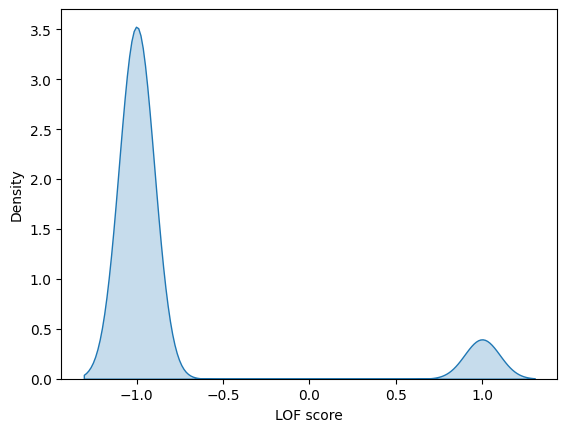

In [164]:

# Fit the LOF model to the data and predict outlier scores
lof = LocalOutlierFactor(n_neighbors=70, contamination='auto', metric='euclidean')
outlier_scores = -lof.fit_predict(df_scaled)

# Create a density plot of the LOF scores
sns.kdeplot(data=outlier_scores, fill=True)
plt.xlabel('LOF score')
plt.show()


In [165]:
# Initialize the LOF model
lof = LocalOutlierFactor(n_neighbors=5, contamination='auto', metric='euclidean')

# Fit the model to the data and predict outlier scores
outlier_scores = -lof.fit_predict(df_scaled)

# Create a boolean column indicating if the row is an LOF outlier
df['isLOFOutlier'] = outlier_scores > 0.9

# Create a string column with the LOF outlier score
df['LOFOutScore'] = outlier_scores.astype(str)

# Filter and print only the rows where isLOFOutlier is True
outlier_rows = df[df['isLOFOutlier'] == True]
print(outlier_rows)



         Score     Kills   Deaths    K/D      Damage  Headshots  Dominations  \
1      37177.0   23354.0  16610.0   1.41  12424189.0     5104.0       2956.0   
3      20899.0  206371.0  16340.0  12.63   8809755.0    13478.0   34534577.0   
7      54648.0   57721.0  22386.0   2.58   3606556.0    16042.0        697.0   
11     37177.0   23354.0  16610.0   1.41  12424189.0     5104.0       2956.0   
13     20899.0  206371.0  16340.0  12.63   8809755.0    13478.0   34534577.0   
...        ...       ...      ...    ...         ...        ...          ...   
7122  181565.0   65840.0  76802.0   0.86   9466803.0    24676.0        353.0   
7142    2749.0    1839.0  39609.0   0.05    267315.0     1448.0         32.0   
7164  148858.0   57885.0  26705.0   2.17   8303395.0    24647.0        915.0   
7179   15372.0    3033.0   6758.0   0.45    438553.0     1088.0         81.0   
7228  227056.0   52514.0  29721.0   1.77   6931638.0    19313.0       1635.0   

      Shots Fired  Shots Hit  Shots Acc

ISOLATION FOREST

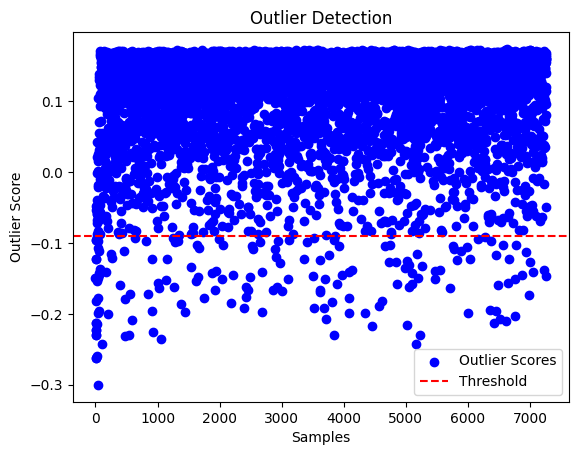

In [166]:
# Convert column names to strings
df.columns = df.columns.astype(str)

# Initialize the Isolation Forest model
clf = IsolationForest()
clf.fit(df)

# Obtain the outlier scores
outlier_scores = clf.decision_function(df)

# Define the threshold
threshold = -0.09

# Select the outliers based on the threshold
outliers = df[outlier_scores < threshold]

# Create a scatter plot of the outlier scores
plt.scatter(range(len(outlier_scores)), outlier_scores, c='blue', label='Outlier Scores')

# Draw a horizontal line for the threshold
plt.axhline(y=threshold, c='red', linestyle='--', label='Threshold')

# Set labels and title
plt.xlabel('Samples')
plt.ylabel('Outlier Score')
plt.title('Outlier Detection')

# Add legend
plt.legend()

# Show the plot
plt.show()

In [184]:
# Create a DataFrame with the outlier scores and isOutlier column
df_outliers_ISOF = pd.DataFrame({'ISOFoutScore': outlier_scores, 'isOutlierISOF': outlier_scores < threshold})

# Merge df_outliers_ISOF with the original DataFrame df based on a common column
df_merged = pd.merge(df, df_outliers_ISOF, left_index=True, right_index=True)

# Filter and print only the rows where isOutlierISOF is True
outliers_true = df_merged[df_merged['isOutlierISOF'] == True]
print(outliers_true)

# Count the number of outliers
outlier_count = outliers_true.shape[0]

# Print the count
print("Number of outliers:", outlier_count)



         Score     Kills    Deaths    K/D      Damage  Headshots  Dominations  \
0      90825.0   64010.0   43415.0   1.47   5469199.0    30791.0        159.0   
1      37177.0   23354.0   16610.0   1.41  12424189.0     5104.0       2956.0   
2     175099.0  377607.0  340137.0   1.11  11308366.0    66327.0        218.0   
3      20899.0  206371.0   16340.0  12.63   8809755.0    13478.0   34534577.0   
4      54966.0   18610.0   27416.0   0.68   2430503.0     5269.0       2141.0   
...        ...       ...       ...    ...         ...        ...          ...   
7258  179769.0   80723.0   89615.0   0.90  11831693.0    39396.0         71.0   
7259   79560.0   37071.0   28097.0   1.32   5610044.0    13123.0         88.0   
7260   51386.0   12197.0   10332.0   1.18   1775002.0     4244.0        134.0   
7261   74422.0   30576.0   34824.0   0.88   4397890.0    13166.0         46.0   
7262   35973.0    9223.0    7104.0   1.30   1246225.0     4093.0        176.0   

      Shots Fired  Shots Hi

PCA

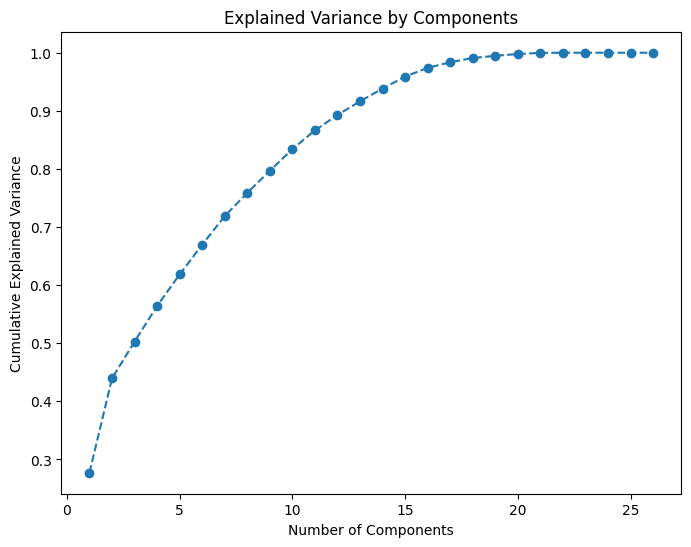

         Score     Kills    Deaths   K/D      Damage  Headshots  Dominations  \
29    115964.0  117776.0  104981.0  1.12   9150656.0    53074.0       1111.0   
32     87236.0   42127.0   29748.0  1.42   5320172.0    22318.0        465.0   
35    104913.0  206077.0  166968.0  1.23   9924339.0    92310.0        451.0   
38     24247.0   11485.0    7584.0  1.51   1618002.0     4885.0         32.0   
43    213347.0   76911.0   59579.0  1.29  10261994.0    33152.0        422.0   
...        ...       ...       ...   ...         ...        ...          ...   
7258  179769.0   80723.0   89615.0  0.90  11831693.0    39396.0         71.0   
7259   79560.0   37071.0   28097.0  1.32   5610044.0    13123.0         88.0   
7260   51386.0   12197.0   10332.0  1.18   1775002.0     4244.0        134.0   
7261   74422.0   30576.0   34824.0  0.88   4397890.0    13166.0         46.0   
7262   35973.0    9223.0    7104.0  1.30   1246225.0     4093.0        176.0   

      Shots Fired  Shots Hit  Shots Acc

In [185]:
# First, we should determine the number of components
pca = PCA()
df_pca = pca.fit_transform(df_scaled)

# Plotting the explained variance ratio for each component
plt.figure(figsize=(8,6))
plt.plot(range(1, df_scaled.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.show()

# Let's suppose the optimal number of components is n_components
n_components = 26

pca = PCA(n_components=n_components)
df_pca = pca.fit_transform(df_scaled)

# Detect outliers in the lower-dimensional space
iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(df_pca)

# Select all rows that are not outliers
mask = yhat != -1
df_no_outliers = df[mask]

print(df_no_outliers)


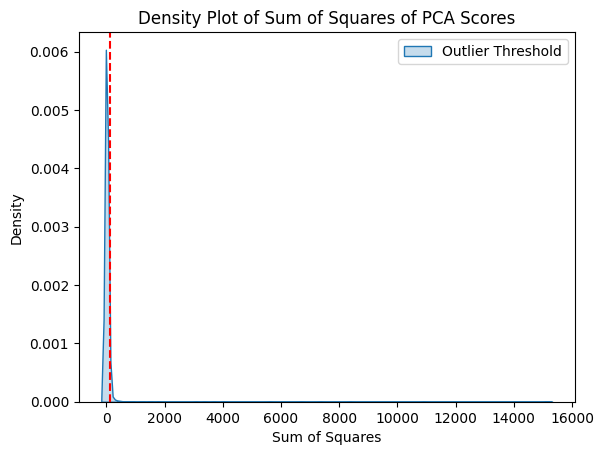

In [186]:
# Create the density plot
sns.kdeplot(sum_of_squares, fill=True)

# Add a vertical line to denote the threshold for outliers
plt.axvline(x=threshold, color='r', linestyle='--')

# Show the plot with labels
plt.title('Density Plot of Sum of Squares of PCA Scores')
plt.xlabel('Sum of Squares')
plt.ylabel('Density')
plt.legend(['Outlier Threshold'])
plt.show()

In [187]:
# Calculate PCA scores based on the transformed PCA data
pca_scores = df_pca

# Calculate the sum of squares of the PCA scores
sum_of_squares = np.sum(pca_scores**2, axis=1)

# Determine the threshold based on the 98th percentile of the sum of squares
threshold = np.percentile(sum_of_squares, 98)

# Determine outliers
outliers = sum_of_squares > threshold

# Create a boolean column indicating if the row is a PCA outlier
df['isOutlierPCA'] = outliers

# Create a string column with the PCA outlier score
df['PCAOutScore'] = sum_of_squares.astype(str)

# Print the rows that are outliers
outliers_df = df[df['isOutlierPCA'] == True]
print(outliers_df[['isOutlierPCA', 'PCAOutScore']])

# Count the number of outliers
outlier_count = len(outliers_df)
print("Number of outliers based on PCA:", outlier_count)


      isOutlierPCA         PCAOutScore
0             True  1510.4335808060696
1             True  1228.3411201958434
2             True   515.1219396850922
3             True  15144.441000820594
4             True   255.1595002818647
...            ...                 ...
7025          True  206.42228990819314
7039          True   234.3085920829958
7045          True   265.5177251068231
7224          True   382.3614399537806
7255          True   296.7551577330279

[146 rows x 2 columns]
Number of outliers based on PCA: 146


# PART 3: Results: Majority Voting

In [188]:
# check the data for more accuracy
# get the number of variables (columns)
num_vars = df.shape[1]

# print the number of variables
print('The number of variables is:', num_vars)

num_rows = df.shape[0]

# print the number of rows
print('The number of rows is:', num_rows)

# print the first 5 rows of the data frame to check if it was read correctly
print(df.head())

The number of variables is: 34
The number of rows is: 7263
      Score     Kills    Deaths    K/D      Damage  Headshots  Dominations  \
0   90825.0   64010.0   43415.0   1.47   5469199.0    30791.0        159.0   
1   37177.0   23354.0   16610.0   1.41  12424189.0     5104.0       2956.0   
2  175099.0  377607.0  340137.0   1.11  11308366.0    66327.0        218.0   
3   20899.0  206371.0   16340.0  12.63   8809755.0    13478.0   34534577.0   
4   54966.0   18610.0   27416.0   0.68   2430503.0     5269.0       2141.0   

   Shots Fired  Shots Hit  Shots Accuracy  ...  Win %  Headshot %  \
0     445411.0    92913.0            20.9  ...   49.9        48.1   
1    2156088.0  1385405.0            64.3  ...   58.1        21.9   
2    1022660.0   591692.0            57.9  ...   36.8        17.6   
3     216841.0    98468.0            45.4  ...   48.5         6.5   
4     294100.0    73146.0            24.9  ...   91.8        28.3   

   isOutlierMahan  MahanOutScore  isLOFOutlier  LOFOutSco

In [191]:
# Filter and print the rows where all the specified columns are True
joint_outliers = df[(df['isOutlierMahan'] == True) & (df['isLOFOutlier'] == True) & (df['isOutlierPCA'] == True) & (df['isKNNOutlier'] == True)]
print(joint_outliers)


            Score      Kills    Deaths    K/D       Damage  Headshots  \
1         37177.0    23354.0   16610.0   1.41   12424189.0     5104.0   
3         20899.0   206371.0   16340.0  12.63    8809755.0    13478.0   
11        37177.0    23354.0   16610.0   1.41   12424189.0     5104.0   
13        20899.0   206371.0   16340.0  12.63    8809755.0    13478.0   
26    123483767.0    58895.0  117346.0   0.50    8716267.0    25966.0   
30       117486.0    65614.0  118528.0   0.55   13210226.0    33154.0   
36       259821.0  2371607.0  121563.0  19.51    6562036.0   157721.0   
39       212176.0    94504.0  102421.0   0.92   13363598.0    51901.0   
40        38648.0    26984.0   15821.0   1.71   26725374.0    10192.0   
44     30200048.0    77365.0   64527.0   1.20   10822423.0    26022.0   
70       132840.0    63110.0   30651.0   2.06  988864625.0    16892.0   
1133     320465.0   107883.0   87178.0   1.24  244372563.0    54172.0   
2396     234119.0   109835.0   58387.0   1.88    90

In [196]:
# Filter and print the selected columns for the rows where all the specified columns are True
joint_outliers = df[(df['isOutlierMahan']) & (df['isLOFOutlier']) & (df['isOutlierPCA']) & (df['isKNNOutlier'])]
selected_columns = ['MahanOutScore', 'PCAOutScore', 'KNNOutScore', 'LOFOutScore']
print(joint_outliers[selected_columns])

      MahanOutScore         PCAOutScore          KNNOutScore LOFOutScore
1       2006.769324  1228.3411201958434   0.7631199822953771           1
3     434054.649089  15144.441000820594    2.140104737609778           1
11      2006.769324   1228.341120195846   0.7631199822953771           1
13    434054.649089  15144.441000820618    2.140104737609778           1
26      5887.774027   6696.503363928038   1.0015654760885078           1
30      8934.009875   8375.775294709036    1.195570884973045           1
36      2930.695639   3071.156594233238    1.375111786334389           1
39      1901.482697  4021.7059603610996   0.9789359451905363           1
40      3763.480928   3686.955449568173   1.0013365608342872           1
44      1434.316255  396.42746846665045  0.24358881397718035           1
70     11802.681227  10894.980717121489     1.39376308450968           1
1133    1104.418856  250.92883116921664  0.24360230311722597           1
2396   19272.135465   7350.982910980764   1.0114988

In [198]:
# Filter the DataFrame for the rows where all the specified columns are True
joint_outliers = df[(df['isOutlierMahan']) & (df['isLOFOutlier']) & (df['isOutlierPCA']) & (df['isKNNOutlier'])]

# Perform majority voting
majority_vote = joint_outliers[['isOutlierMahan', 'isLOFOutlier', 'isOutlierPCA', 'isKNNOutlier']].mode(axis=1)

# Add the majority vote as a new column using .loc
joint_outliers.loc[:, 'MajorityVote'] = majority_vote[0].values

# Print the updated DataFrame with the majority vote
print(joint_outliers)



            Score      Kills    Deaths    K/D       Damage  Headshots  \
1         37177.0    23354.0   16610.0   1.41   12424189.0     5104.0   
3         20899.0   206371.0   16340.0  12.63    8809755.0    13478.0   
11        37177.0    23354.0   16610.0   1.41   12424189.0     5104.0   
13        20899.0   206371.0   16340.0  12.63    8809755.0    13478.0   
26    123483767.0    58895.0  117346.0   0.50    8716267.0    25966.0   
30       117486.0    65614.0  118528.0   0.55   13210226.0    33154.0   
36       259821.0  2371607.0  121563.0  19.51    6562036.0   157721.0   
39       212176.0    94504.0  102421.0   0.92   13363598.0    51901.0   
40        38648.0    26984.0   15821.0   1.71   26725374.0    10192.0   
44     30200048.0    77365.0   64527.0   1.20   10822423.0    26022.0   
70       132840.0    63110.0   30651.0   2.06  988864625.0    16892.0   
1133     320465.0   107883.0   87178.0   1.24  244372563.0    54172.0   
2396     234119.0   109835.0   58387.0   1.88    90

<ipython-input-198-632e2e840d89>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  joint_outliers.loc[:, 'MajorityVote'] = majority_vote[0].values


In [202]:
from tabulate import tabulate

# Define the outlier rows
outlier_rows = [
    [1, True],
    [3, True],
    [11, True],
    [13, True],
    [26, True],
    [30, True],
    [36, True],
    [39, True],
    [40, True],
    [44, True],
    [70, True],
    [1133, True],
    [2396, True]
]

# Create the table
table = tabulate(outlier_rows, headers=['Row Number', 'Is Outlier'], tablefmt='grid')

# Print the table
print(table)


+--------------+--------------+
|   Row Number | Is Outlier   |
+==============+==============+
|            1 | True         |
+--------------+--------------+
|            3 | True         |
+--------------+--------------+
|           11 | True         |
+--------------+--------------+
|           13 | True         |
+--------------+--------------+
|           26 | True         |
+--------------+--------------+
|           30 | True         |
+--------------+--------------+
|           36 | True         |
+--------------+--------------+
|           39 | True         |
+--------------+--------------+
|           40 | True         |
+--------------+--------------+
|           44 | True         |
+--------------+--------------+
|           70 | True         |
+--------------+--------------+
|         1133 | True         |
+--------------+--------------+
|         2396 | True         |
+--------------+--------------+
